# Analysis of Ariane Qualitative Runs

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt, animation
import xarray as xr
import numpy as np
import pandas as pd
import cmocean as cm
from datetime import datetime
from IPython.display import HTML
import netCDF4 as nc

## test run with SalishSeaCast

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/salish_qual/forward_01mar19/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

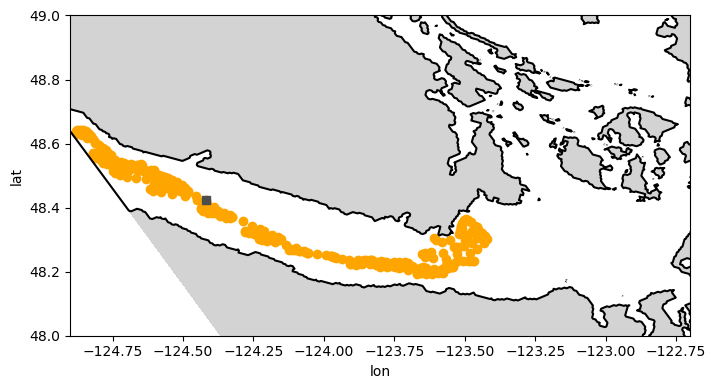

In [3]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

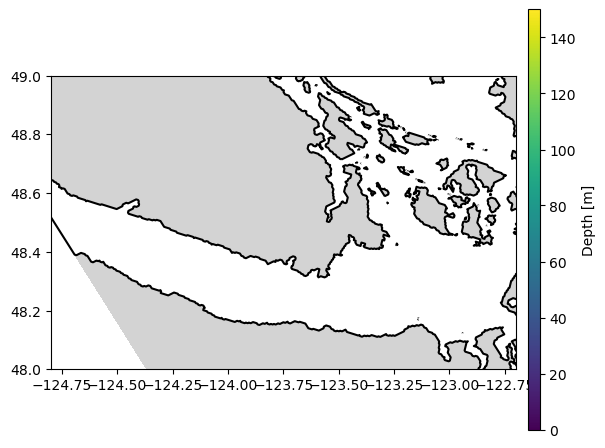

In [4]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
#     tstamp = file.traj_time[hour, 0].values.astype('datetime64[s]').astype(datetime)
#     t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [5]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

## CIOPS BC12
#### first: lets make some smart choices about where to put the particles!

In [3]:
# date = datetime(2016,1,1)
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_file = "/ocean/rbeutel/data/201801/U_new_20180101.nc"
nc_to_plot = xr.open_dataset(nc_file)
mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

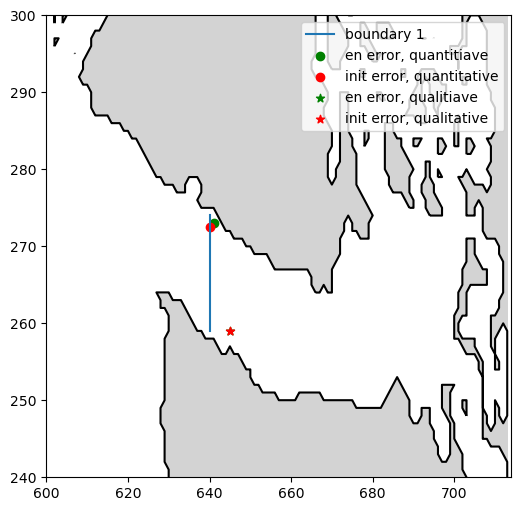

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim(600, 714)
# ax.set_ylim(200,400)
ax.set_ylim(240,300)
ax.plot([640,640], [259,274], label='boundary 1')
ax.scatter(641, 273, c='g', label='en error, quantitiave')
ax.scatter(640, 272.5, c='r', label='init error, quantitative')
ax.scatter(645, 259, c='g', marker = '*', label='en error, qualitiave')
ax.scatter(645.01, 259.01, c='r', marker="*", label='init error, qualitative')
ax.legend()

Text(0.5, 1.0, 'Depth = 70')

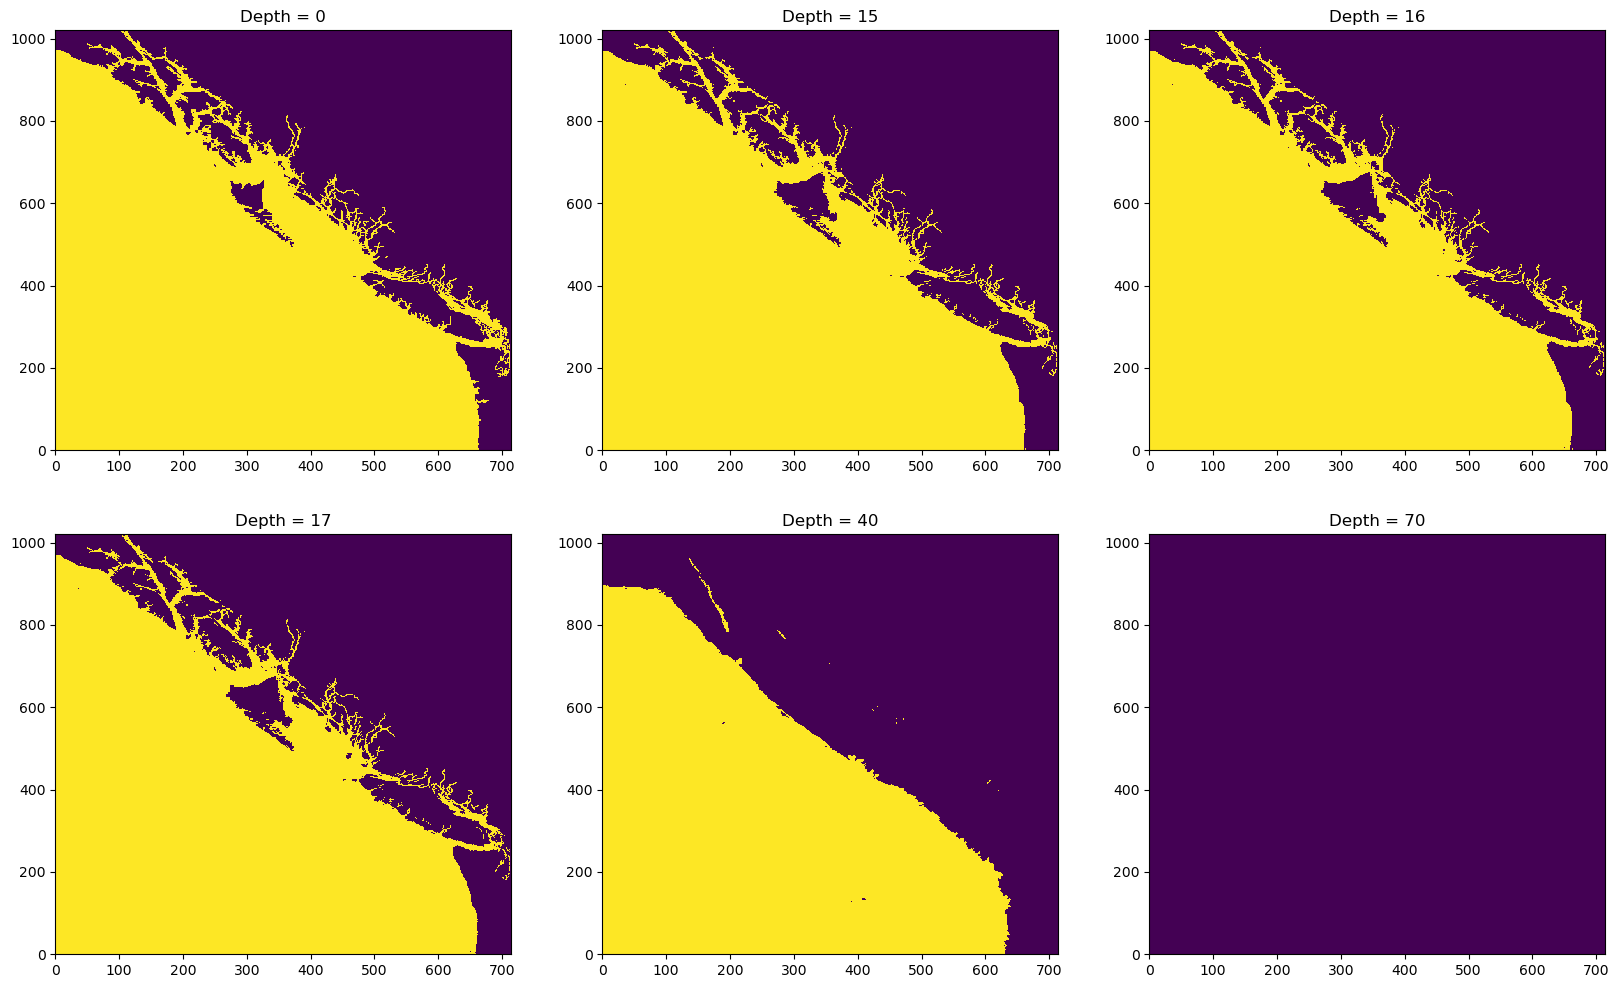

In [20]:
#lets plot the whole tmask domain
# depths = np.arange(0,20,1)
d = [0, 15, 16, 17, 40, 70]
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(20,12))

ax[0,0].pcolormesh(mesh.tmask[0,d[0],:,:])
ax[0,0].set_title("Depth = " + str(d[0]))
ax[0,1].pcolormesh(mesh.tmask[0,d[1],:,:])
ax[0,1].set_title("Depth = " + str(d[1]))
ax[0,2].pcolormesh(mesh.tmask[0,d[2],:,:])
ax[0,2].set_title("Depth = " + str(d[2]))

ax[1,0].pcolormesh(mesh.tmask[0,d[0+3],:,:])
ax[1,0].set_title('Depth = '+ str(d[3]))
ax[1,1].pcolormesh(mesh.tmask[0,d[1+3],:,:])
ax[1,1].set_title('Depth = '+ str(d[4]))
ax[1,2].pcolormesh(mesh.tmask[0,d[2+3],:,:])
ax[1,2].set_title('Depth = '+ str(d[5]))
# this is where it says the false start is occuring! but where the false start is (this x and y, depth=16) water exists!

### ^nothing overtly insane to me!

In [24]:
# quick check
mesh.tmask[0,:,:,:].max()

<xarray.DataArray 'tmask' ()>
array(1, dtype=int8)

In [25]:
mesh.tmask[0,:,:,:].min()

<xarray.DataArray 'tmask' ()>
array(0, dtype=int8)

### ^the max and min values are exactly what they are supposed to be!

<ipython-input-16-2d87d853e7cd>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  tmesh = ax[hour//6,k].pcolormesh(X,Y,data.T, cmap = cm.cm.balance, \


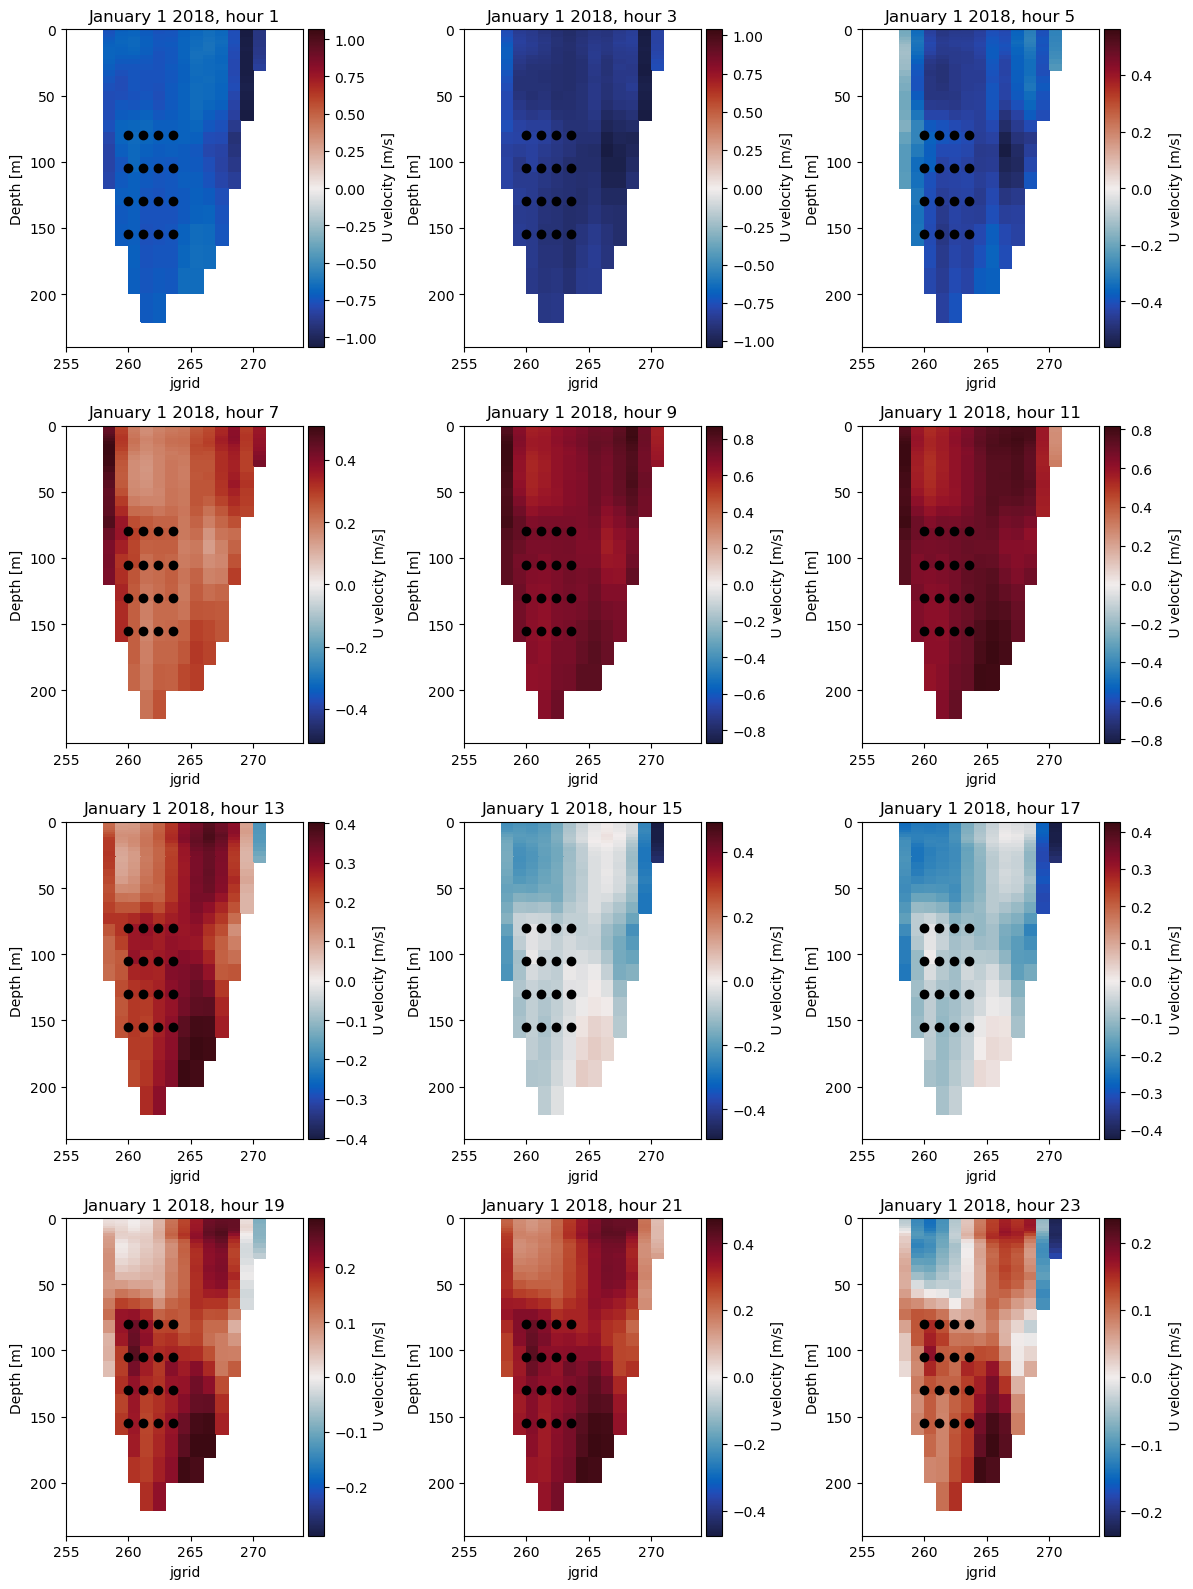

In [16]:
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_to_plot = nc.Dataset(nc_file)
mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

# hours = [0, 3, 6, 12, 15, 18, 21, 24]
hours = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

variable = 'vozocrtx'
fig, ax= plt.subplots(nrows=4, ncols=3, figsize =(12,16))

igrid = 646-1
latS = 255
latN = 275
k = 0

for hour in hours:
    data = nc_to_plot[variable][hour,latS:latN,igrid,:]
    # X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
    section_slice = np.arange(latS,latN)
    zlevels = mesh_nc['gdept_1d'][:][0]
    X, Y = np.meshgrid(section_slice, zlevels)
    tmesh = ax[hour//6,k].pcolormesh(X,Y,data.T, cmap = cm.cm.balance, \
                          vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

    ax[hour//6,k].set_ylim([0,240])
    ax[hour//6,k].invert_yaxis()
    ax[hour//6,k].set_ylabel('Depth [m]')
    ax[hour//6,k].set_xlabel('jgrid')
    ax[hour//6,k].set_title('January 1 2018, hour '+str(hour+1))
    
    cbar = fig.colorbar(tmesh, ax=ax[hour//6,k], orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
    cbar.set_label(label=' U velocity [m/s]') 
    
    # particle location evenly arangedthrough lower half of water column
#     ax[hour//6,k].scatter([260,260,260,262.3,262.3,262.3,262.3,264.7,264.7,264.7,264.7,267,267,267],[90,120,150, 90,120, 150, 180, 90,120, 150, 180,90, 120, 150],c='k')
    # particle location focused in area of high influx (from SSC JR CSs)
    ax[hour//6,k].scatter([260,260,260,260, 261.2,261.2,261.2,261.2,262.4,262.4,262.4,262.4,263.6,263.6,263.6,263.6],[80,105,130,155, 80,105,130,155,80,105,130,155,80,105,130,155],c='k')
    #once i get CIOPS to work i honestly think i should do both particle location schemes
    
    if k ==2:
        k = 0
    else:
        k +=1 
    
plt.tight_layout()

# ax[1].scatter([261,261,261,263.5,263.5,263.5,263.5,266,266,266],[90,120,150, 90,120, 150, 180, 90, 120, 150],c='k')

In [9]:
#now for ariane you cannot set the position at a depth of 90 bc that will put it incell 90 (which doesn't exist)
#instead find with depth grid cell that best corresponds with the positions you chose above
[(x,y) for (x,y) in enumerate(zlevels)]

[(0, 0.507530023512452),
 (1, 1.557569488842656),
 (2, 2.6693409194084996),
 (3, 3.857884935301262),
 (4, 5.141913831146915),
 (5, 6.544535333853228),
 (6, 8.093971465979628),
 (7, 9.824157673695284),
 (8, 11.775044353140647),
 (9, 13.992364711100425),
 (10, 16.52661505451083),
 (11, 19.43106879090391),
 (12, 22.758861118719427),
 (13, 26.559531476793033),
 (14, 30.875785062827266),
 (15, 35.74142752531527),
 (16, 41.181253706626364),
 (17, 47.21313511579986),
 (18, 53.85189559955382),
 (19, 61.11412039354691),
 (20, 69.02298960174267),
 (21, 77.61249605846115),
 (22, 86.93079063628434),
 (23, 97.04271072951805),
 (24, 108.03171341445899),
 (25, 120.0014691078047),
 (26, 133.0773268246376),
 (27, 147.4077864359136),
 (28, 163.16603544640805),
 (29, 180.55153922041305),
 (30, 199.79161550620404),
 (31, 221.14287374964496),
 (32, 244.8923539986389),
 (33, 271.3581577853082),
 (34, 300.8893252934304),
 (35, 333.8646831888884),
 (36, 370.6903722478645),
 (37, 411.79577220550027),
 (38, 457

SO 90 m=22, 120 m=25, 150 m=27, and 180 m=29

Text(0, 0.5, 'lat')

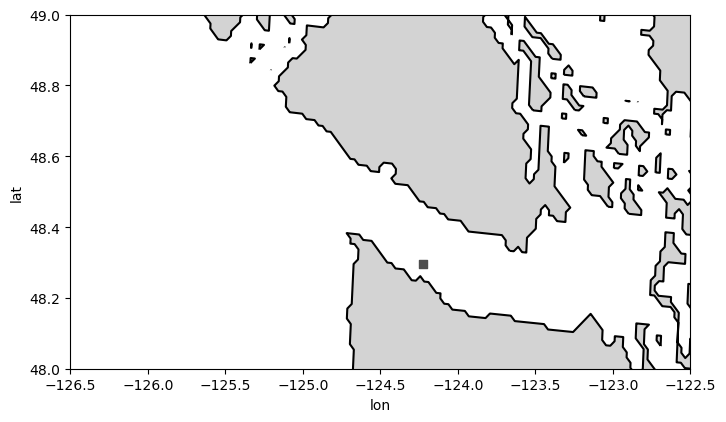

In [10]:
# plot the april run we did with 1 parcel
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/forward_02apr18/ariane_trajectories_qualitative.nc')

fig, ax = plt.subplots(1,1,figsize=(8,4.6))
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-126.5, -122.5])
ax.set_ylim([48, 49])

# ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

In [11]:
file

<xarray.Dataset>
Dimensions:       (nb_output: 241, ntraj: 1)
Dimensions without coordinates: nb_output, ntraj
Data variables:
    init_x        (ntraj) float64 ...
    init_y        (ntraj) float64 ...
    init_z        (ntraj) float64 ...
    init_t        (ntraj) float64 ...
    init_age      (ntraj) timedelta64[ns] ...
    init_transp   (ntraj) float64 ...
    final_x       (ntraj) float64 ...
    final_y       (ntraj) float64 ...
    final_z       (ntraj) float64 ...
    final_t       (ntraj) float64 ...
    final_age     (ntraj) timedelta64[ns] ...
    final_transp  (ntraj) float64 ...
    traj_lon      (nb_output, ntraj) float64 ...
    traj_lat      (nb_output, ntraj) float64 ...
    traj_depth    (nb_output, ntraj) float64 ...
    traj_time     (nb_output, ntraj) float64 ...
Attributes:
    key_roms:                  .FALSE.
    key_mars:                  .FALSE.
    key_symphonie:             .FALSE.
    key_B2C_grid:              .FALSE.
    key_sequential:            .TRUE.
    key_alltracers:            .FALSE.
    key_ascii_outputs:         .TRUE.
    key_iU_jV_kW:              .FALSE.
    key_read_age:              .FALSE.
    mode:                      qualitative
    forback:                   forward
    bin:                       nobin
    init_final:                init
    nmax:                      1
    tunit:                     3600.0
    ntfic:                     1
    tcyc:                      864000.0
    key_approximatesigma:      .TRUE.
    key_computesigma:          .FALSE.
    zsigma:                    1000.0
    memory_log:                .TRUE.
    output_netcdf_large_file:  .FALSE.
    key_interp_temporal:       .FALSE.
    maxcycles:                 1
    delta_t:                   3600.0
    frequency:                 1
    nb_output:                 240
    mask:                      .FALSE.
    key_region:                .FALSE.
    imt:                       714
    jmt:                       1020
    kmt:                       75
    lmt:                       240
    key_computew:              .TRUE.
    w_surf_option:             
    key_partialsteps:          .TRUE.
    key_jfold:                 .FALSE.
    pivot:                     T
    key_periodic:              .FALSE.
    dir_mesh:                  /ocean/mdunphy/CIOPSW-BC12/grid/
    fn_mesh:                   mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_...
    nc_var_xx_tt:              glamt
    nc_var_xx_uu:              glamu
    nc_var_yy_tt:              gphit
    nc_var_yy_vv:              gphiv
    nc_var_zz_ww:              gdepw_0
    nc_var_e2u:                e2u
    nc_var_e1v:                e1v
    nc_var_e1t:                e1t
    nc_var_e2t:                e2t
    nc_var_e3t:                e3t_0
    nc_var_tmask:              tmask
    nc_mask_val:               0.0
    c_dir_zo:                  Links
    c_prefix_zo:               CIOPS_1h_
    ind0_zo:                   1
    indn_zo:                   30
    maxsize_zo:                6
    c_suffix_zo:               _grid_U.nc
    nc_var_zo:                 vozocrtx
    nc_var_eivu:               NONE
    nc_att_mask_zo:            NONE
    c_dir_me:                  Links
    c_prefix_me:               CIOPS_1h_
    ind0_me:                   1
    indn_me:                   30
    maxsize_me:                6
    c_suffix_me:               _grid_V.nc
    nc_var_me:                 vomecrty
    nc_var_eivv:               NONE
    nc_att_mask_me:            NONE

In [12]:
source_file = xr.open_dataset('/ocean/rbeutel/data/201804/U_new_20180402.nc')

In [17]:
source_file.vozocrtx[10,647,261,:]

<xarray.DataArray 'vozocrtx' (depthu: 75)>
array([-0.047834, -0.051059, -0.051401, -0.051673, -0.051925, -0.052187,
       -0.052443, -0.052688, -0.05293 , -0.053149, -0.053297, -0.053218,
       -0.05253 , -0.049992, -0.042941, -0.034926, -0.027735, -0.023575,
       -0.018872, -0.019139, -0.017447, -0.016793, -0.010807,  0.002232,
        0.022103,  0.041477,  0.046992,  0.04196 ,  0.039123,  0.042047,
        0.040009,  0.052496,  0.063393,  0.051586,  0.022031,  0.075985,
        0.122076,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan])
Coordinates:
    time_counter  datetime64[ns] 2018-04-02T11:00:00
    nav_lat       float32 ...
    nav_lon       float32 ...
  * depthu        (depthu) float32 0.5075 1.558 2.669 ... 5.698e+03 5.902e+03

In [18]:
source_file = xr.open_dataset('/ocean/rbeutel/data/201804/V_new_20180402.nc')

In [20]:
source_file.vomecrty[10,647,261,:]

<xarray.DataArray 'vomecrty' (depthv: 75)>
array([-0.129971, -0.1275  , -0.126754, -0.125928, -0.125268, -0.124657,
       -0.124005, -0.123319, -0.12256 , -0.121695, -0.120697, -0.119539,
       -0.11771 , -0.114919, -0.113326, -0.114461, -0.112336, -0.107065,
       -0.105064, -0.102449, -0.09588 , -0.088853, -0.079665, -0.069147,
       -0.058054, -0.056226, -0.065288, -0.075941, -0.084998, -0.091004,
       -0.093257, -0.092598, -0.099916, -0.084377, -0.076926, -0.116258,
       -0.114146,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan])
Coordinates:
    time_counter  datetime64[ns] 2018-04-02T11:00:00
    nav_lat       float32 ...
    nav_lon       float32 ...
  * depthv        (depthv) float32 0.5075 1.558 2.669 ... 5.698e+03 5.902e+03

In [23]:
mesh.fmask[0,:,647,261]

<xarray.DataArray 'fmask' (z: 75)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int8)
Dimensions without coordinates: z

depth at the location where coast crash is occuring goes down to cell 37 (U, V, and mesh agree) - then why is a crash occuring at 31??<br>
look at the surrouding cells? -> does not look like this is the issue :( <br>
check the source files that DO work and see what number signifies land?

In [38]:
other_source = xr.open_dataset("/ocean/mdunphy/NEP36-GPSC4-VAH006/NEP36-GPSC4-VAH006_5d_grid_U_20071122-20071126.nc")

In [40]:
other_source.uo[0,:,647,261]

<xarray.DataArray 'uo' (depthu: 50)>
array([-0.00347 , -0.003384, -0.003282, -0.003181, -0.003087, -0.002996,
       -0.002908, -0.002818, -0.002714, -0.002602, -0.002481, -0.002361,
       -0.002239, -0.002149, -0.002112, -0.002036, -0.00343 , -0.003519,
       -0.000342,  0.00383 ,  0.009414,  0.004714, -0.006266, -0.012239,
       -0.016021, -0.012191, -0.011351,  0.010833,  0.033127,  0.015774,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      , -0.      ], dtype=float32)
Coordinates:
    nav_lat        float32 ...
    nav_lon        float32 ...
  * depthu         (depthu) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    time_centered  datetime64[ns] 2007-11-24T12:00:00
    time_counter   datetime64[ns] 2007-11-24T12:00:00
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           sea_water_x_velocity
    units:               m/s
    online_operation:    average
    interval_operation:  60 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 60 s)

In [41]:
other_source = xr.open_dataset('/data/rbeutel/analysis/ssc_tidesback/U_new_20190930.nc')

In [43]:
other_source.vozocrtx[10,377,45,:]

<xarray.DataArray 'vozocrtx' (depthu: 40)>
array([-0.005437, -0.000857,  0.001321,  0.002163,  0.0028  ,  0.004641,
        0.006617,  0.007996,  0.008726,  0.009639,  0.011965,  0.014341,
        0.016623,  0.018082,  0.018189,  0.019374,  0.020502,  0.021947,
        0.023951,  0.025436,  0.028342,  0.029948,  0.033057,  0.051621,
        0.069164,  0.184071,  0.170106,  0.243004,  0.218103,  0.219524,
        0.211147,  0.162933,  0.162933,  0.162933,  0.162933,  0.162933,
        0.162933,  0.162933,  0.162933,  0.162933], dtype=float32)
Coordinates:
    time_counter  datetime64[ns] 2019-09-30T10:30:00
    nav_lat       float32 ...
    nav_lon       float32 ...
  * depthu        (depthu) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5

In [ ]:
xr.open_dataset('/results2/')